# Required Packages

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!pip install shap;
!pip install catboost;
!pip install Optuna;
!pip install ipywidgets;
!jupyter nbextension enable --py widgetsnbextension;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.6 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import time
from joblib import dump, load

import catboost as cb
from catboost import CatBoostClassifier, Pool, metrics, cv
from catboost.utils import eval_metric
import shap
import optuna
import lightgbm as lgb
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import (train_test_split, cross_val_score)

from google.colab import output
output.enable_custom_widget_manager()

RANDOME_STATE = 42
TIMEOUT_SECONDS = 300

from IPython.display import display, HTML
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
print("CatBoost version:", cb.__version__)
print("Pandas version:", pd.__version__)
print("Sklearn version:", sklearn.__version__)

CatBoost version: 1.2.2
Pandas version: 1.5.3
Sklearn version: 1.2.2


# **Reading And Understanding Data**

* Load dataset
* Some statistical Computation

In [43]:
df = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/network_traffic_data.csv')

In [6]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,...,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,5480074,3,1,12,0,6,0,4.000,3.465,0,0,0.0,0.0,2.189751,0.729917,1.826691e+06,3.131700e+06,5442804,101,5480074,2740037.000,3.822290e+06,5442804,37270,...,0.0,72,0,0,0,0,0,0,3,12,1,0,8192,42780,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,711977,9,10,703,3950,267,0,78.100,103.300,1448,0,395.0,587.5,6535.323473,26.686255,3.955428e+04,5.015462e+04,120501,1,616301,77037.625,7.299598e+04,215614,230,...,395.0,296,0,0,0,0,0,0,9,703,10,3950,29200,252,4,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,153398,2,2,80,224,40,40,40.000,0.000,112,112,112.0,0.0,1981.772904,26.075959,5.113267e+04,8.855831e+04,153391,3,3,3.000,0.000000e+00,3,3,...,112.0,40,0,0,0,0,0,0,2,80,2,224,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,57660,1,1,46,128,46,46,46.000,0.000,128,128,128.0,0.0,3017.689906,34.686091,5.766000e+04,0.000000e+00,57660,57660,0,0.000,0.000000e+00,0,0,...,128.0,20,0,0,0,0,0,0,1,46,1,128,-1,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.336,14.440,6,6,6.0,0.0,63885.267280,5215.123859,2.556667e+02,3.942896e+02,710,3,713,356.500,4.999245e+02,710,3,...,6.0,60,0,0,0,0,0,0,3,43,1,6,1017,0,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Преобразуем имена столбцов

In [7]:
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

Предположительное описание колонок:  
- 'destination_port': Порт назначения, на который отправляется сетевой трафик.
- 'flow_duration': Продолжительность потока сетевого трафика.
- 'total_fwd_packets': Общее количество пакетов, отправленных вперед.
- 'total_backward_packets': Общее количество пакетов, отправленных назад.
- 'total_length_of_fwd_packets': Общая длина пакетов, отправленных вперед.
- 'total_length_of_bwd_packets': Общая длина пакетов, отправленных назад.
- 'fwd_packet_length_max': Максимальная длина пакета в направлении вперед.
- 'fwd_packet_length_min': Минимальная длина пакета в направлении вперед.
- 'fwd_packet_length_mean': Средняя длина пакета в направлении вперед.
- 'fwd_packet_length_std': Стандартное отклонение длины пакетов в направлении вперед.
- 'bwd_packet_length_max': Максимальная длина пакета в направлении назад.
- 'bwd_packet_length_min': Минимальная длина пакета в направлении назад.
- 'bwd_packet_length_mean': Средняя длина пакета в направлении назад.
- 'bwd_packet_length_std': Стандартное отклонение длины пакетов в направлении назад.
- 'flow_bytes/s': Скорость передачи байтов в потоке.
- 'flow_packets/s': Скорость передачи пакетов в потоке.
- 'flow_iat_mean': Средний межпакетный интервал в потоке.
- 'flow_iat_std': Стандартное отклонение межпакетного интервала в потоке.
- 'flow_iat_max': Максимальный межпакетный интервал в потоке.
- 'flow_iat_min': Минимальный межпакетный интервал в потоке.
- 'fwd_iat_total': Общий интервал между пакетами в направлении вперед.
- 'fwd_iat_mean': Средний интервал между пакетами в направлении вперед.
- 'fwd_iat_std': Стандартное отклонение интервала между пакетами в направлении вперед.
- 'fwd_iat_max': Максимальный интервал между пакетами в направлении вперед.
- 'fwd_iat_min': Минимальный интервал между пакетами в направлении вперед.
- 'bwd_iat_total': Общий интервал между пакетами в направлении назад.
- 'bwd_iat_mean': Средний интервал между пакетами в направлении назад.
- 'bwd_iat_std': Стандартное отклонение интервала между пакетами в направлении назад.
- 'bwd_iat_max': Максимальный интервал между пакетами в направлении назад.
- 'bwd_iat_min': Минимальный интервал между пакетами в направлении назад.
- 'fwd_psh_flags': Количество флагов PSH в направлении вперед.
- 'bwd_psh_flags': Количество флагов PSH в направлении назад.
- 'fwd_urg_flags': Количество флагов URG в направлении вперед.
- 'bwd_urg_flags': Количество флагов URG в направлении назад.
- 'fwd_header_length': Длина заголовка в направлении вперед.
- 'bwd_header_length': Длина заголовка в направлении назад.
- 'fwd_packets/s': Скорость передачи пакетов в направлении вперед.
- 'bwd_packets/s': Скорость передачи пакетов в направлении назад.
- 'min_packet_length': Минимальная длина пакета.
- 'max_packet_length': Максимальная длина пакета.
- 'packet_length_mean': Средняя длина пакета.
- 'packet_length_std': Стандартное отклонение длины пакетов.
- 'packet_length_variance': Дисперсия длины пакетов.
- 'fin_flag_count': Количество флагов FIN.
- 'syn_flag_count': Количество флагов SYN.
- 'rst_flag_count': Количество флагов RST.
- 'psh_flag_count': Количество флагов PSH.
- 'ack_flag_count': Количество флагов ACK.
- 'urg_flag_count': Количество флагов URG.
- 'cwe_flag_count': Количество флагов CWE.
- 'ece_flag_count': Количество флагов ECE.
- 'down/up_ratio': Отношение вниз/вверх (Down/Up).
- 'average_packet_size': Средний размер пакета.
- 'avg_fwd_segment_size': Средний размер сегмента в направлении вперед.
- 'avg_bwd_segment_size': Средний размер сегмента в направлении назад.
- 'fwd_header_length.1': Дополнительная длина заголовка в направлении вперед.
- 'subflow_fwd_packets': Количество подпотоков пакетов в направлении вперед.
- 'subflow_fwd_bytes': Количество подпотоков байтов в направлении вперед.
- 'subflow_bwd_packets': Количество подпотоков пакетов в направлении назад.
- 'subflow_bwd_bytes': Количество подпотоков байтов в направлении назад.
- 'init_win_bytes_forward': Начальный размер окна (в байтах) в направлении вперед.
- 'init_win_bytes_backward': Начальный размер окна (в байтах) в направлении назад.
- 'act_data_pkt_fwd': Количество активных пакетов данных в направлении вперед.
- 'min_seg_size_forward': Минимальный размер сегмента в направлении вперед.
- 'active_mean': Среднее значение активности.
- 'active_std': Стандартное отклонение активности.
- 'active_max': Максимальное значение активности.
- 'active_min': Минимальное значение активности.
- 'idle_mean': Среднее значение простоя (бездействия).
- 'idle_std': Стандартное отклонение простоя (бездействия).
- 'idle_max': Максимальное значение простоя (бездействия).
- 'idle_min': Минимальное значение простоя (бездействия).


In [8]:
df.label.unique()

array(['BENIGN', 'PortScan', 'DoS Hulk', 'DDoS', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS GoldenEye', 'Heartbleed'],
      dtype=object)

- BENIGN: Эта метка обычно представляет нормальный и не злонамеренный сетевой трафик. Она используется как базовый уровень или эталон для сравнения с потенциально злонамеренными действиями.

- PortScan: Это попытка идентифицировать открытые порты на целевой системе, что может являться предварительным этапом для более сложных атак.

- DoS Hulk: Эта метка представляет атаку типа "Отказ в обслуживании", цель которой - перегрузить систему или сеть, делая её недоступной для пользователей.

- DDoS: Аналогично DoS, но включает в себя множество атакующих машин, что делает её более мощной.

- Bot: Это относится к сетевому трафику, созданному автоматизированными программными агентами, часто используемыми во вредных целях, таких как распространение вредоносных программ или проведение атак.

- Infiltration: Эта метка используется, когда совершается попытка несанкционированного доступа к сети или системе.

- Web Attack - Brute Force: Тип атаки, при котором злоумышленник пытается получить доступ, пробуя множество комбинаций имени пользователя и пароля.

- Web Attack - XSS: Это включает в себя инъекцию злонамеренных скриптов в веб-страницы, просматриваемые другими пользователями.

- Web Attack - SQL Injection: Злоумышленники пытаются использовать уязвимости в веб-приложениях для доступа к базе данных или манипуляции данными, внедряя SQL-код.

- FTP-Patator и SSH-Patator: Эти метки могут относиться к попыткам угадать учетные данные для входа в FTP и SSH через атаки перебора паролей.

- DoS Slowloris и DoS Slowhttptest: Эти представляют собой вариации атаки отказа в обслуживании, при которых злоумышленник пытается поддерживать множество соединений с сервером, исчерпывая его ресурсы.

- DoS GoldenEye: Ещё один вид атаки DoS, целью которой является затопление сервера трафиком и нарушение его работы.

- Heartbleed: Эта метка относится к уязвимости Heartbleed в криптографической библиотеке OpenSSL, которая могла позволить злоумышленнику читать чувствительные данные из памяти сервера.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   destination_port             539616 non-null  int64  
 1   flow_duration                539616 non-null  int64  
 2   total_fwd_packets            539616 non-null  int64  
 3   total_backward_packets       539616 non-null  int64  
 4   total_length_of_fwd_packets  539616 non-null  int64  
 5   total_length_of_bwd_packets  539616 non-null  int64  
 6   fwd_packet_length_max        539616 non-null  int64  
 7   fwd_packet_length_min        539616 non-null  int64  
 8   fwd_packet_length_mean       539616 non-null  float64
 9   fwd_packet_length_std        539616 non-null  float64
 10  bwd_packet_length_max        539616 non-null  int64  
 11  bwd_packet_length_min        539616 non-null  int64  
 12  bwd_packet_length_mean       539616 non-null  float64
 13 

In [10]:
df.iloc[:,:40].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
destination_port,539616.0,5.563061e+03,1.492126e+04,0.000000e+00,80.000000,80.000000,4.430000e+02,65533.0
flow_duration,539616.0,2.106693e+07,3.812172e+07,-1.200000e+01,73.000000,49739.000000,1.064030e+07,119999993.0
total_fwd_packets,539616.0,6.119972e+00,3.451093e+02,1.000000e+00,1.000000,2.000000,6.000000e+00,200755.0
total_backward_packets,539616.0,5.985495e+00,4.634909e+02,0.000000e+00,1.000000,2.000000,5.000000e+00,270686.0
total_length_of_fwd_packets,539616.0,4.082371e+02,7.478351e+03,0.000000e+00,2.000000,44.000000,3.200000e+02,2866110.0
total_length_of_bwd_packets,539616.0,7.999779e+03,1.014442e+06,0.000000e+00,0.000000,105.000000,8.216250e+03,591000000.0
fwd_packet_length_max,539616.0,1.694500e+02,5.605339e+02,0.000000e+00,2.000000,23.000000,2.720000e+02,24820.0
fwd_packet_length_min,539616.0,1.185538e+01,6.096166e+01,0.000000e+00,0.000000,0.000000,6.000000e+00,2065.0
fwd_packet_length_mean,539616.0,4.468101e+01,1.508739e+02,0.000000e+00,2.000000,11.220000,4.856000e+01,5940.0
fwd_packet_length_std,539616.0,5.952510e+01,2.177294e+02,0.000000e+00,0.000000,0.000000,9.170000e+01,7050.0


In [11]:
df.iloc[:,40:].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
packet_length_mean,539616.0,NaN,NaN,NaN,276.581177,416.169617,0.0,3.334,50.8,484.575,2160.0
packet_length_std,539616.0,NaN,NaN,NaN,544.090932,903.656284,0.0,2.191,18.86,812.5,4732.0
packet_length_variance,539616.0,NaN,NaN,NaN,1112687.61947,2468133.747734,0.0,4.8,355.9524,659877.5625,22400000.0
fin_flag_count,539616.0,NaN,NaN,NaN,0.062524,0.242105,0.0,0.0,0.0,0.0,1.0
syn_flag_count,539616.0,NaN,NaN,NaN,0.036747,0.188139,0.0,0.0,0.0,0.0,1.0
rst_flag_count,539616.0,NaN,NaN,NaN,0.00012,0.010975,0.0,0.0,0.0,0.0,1.0
psh_flag_count,539616.0,NaN,NaN,NaN,0.377765,0.484829,0.0,0.0,0.0,1.0,1.0
ack_flag_count,539616.0,NaN,NaN,NaN,0.365884,0.481678,0.0,0.0,0.0,1.0,1.0
urg_flag_count,539616.0,NaN,NaN,NaN,0.060567,0.238535,0.0,0.0,0.0,0.0,1.0
cwe_flag_count,539616.0,NaN,NaN,NaN,0.000056,0.007456,0.0,0.0,0.0,0.0,1.0


In [12]:
df.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

удалим пустые столбцы

In [13]:
selected_columns = df.columns[(df == 0).all() | df.isnull().all()]
selected_columns

Index(['bwd_psh_flags', 'bwd_urg_flags', 'fwd_avg_bytes/bulk',
       'fwd_avg_packets/bulk', 'fwd_avg_bulk_rate', 'bwd_avg_bytes/bulk',
       'bwd_avg_packets/bulk', 'bwd_avg_bulk_rate'],
      dtype='object')

In [14]:
selected_columns
df.drop(columns=selected_columns, inplace=True)

In [15]:
df.duplicated().sum()

64601

In [16]:
#df.drop_duplicates(inplace=True)

In [17]:
df.isna().sum().sum()

488

# **Data Analysis**


*   Data Visualization
*   Data Mining

In [18]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    # Calculate the number of unique values in each column
    nunique = df.nunique()

    # Filter the DataFrame to pick columns with between 1 and 50 unique values
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]

    # Get the number of rows and columns in the filtered DataFrame
    nRow, nCol = df.shape

    # Get the names of the selected columns
    columnNames = list(df)

    # Calculate the number of rows for plotting the graphs
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)

    # Create a figure for plotting with specified size
    plt.figure(num=None, figsize=(6 * nGraphPerRow, 5 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')

    # Loop through each column and create a subplot for each
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]

        # Check if the data type of the column is not a number (e.g., categorical)
        if not np.issubdtype(type(columnDf.iloc[0]), np.number):
            # For non-numeric columns, create a bar graph of value counts
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            # For numeric columns, create a histogram
            columnDf.hist()

        # Set labels, rotation, and title for the subplot
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})', fontsize=16)

    # Adjust subplot layout and display the plots
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()


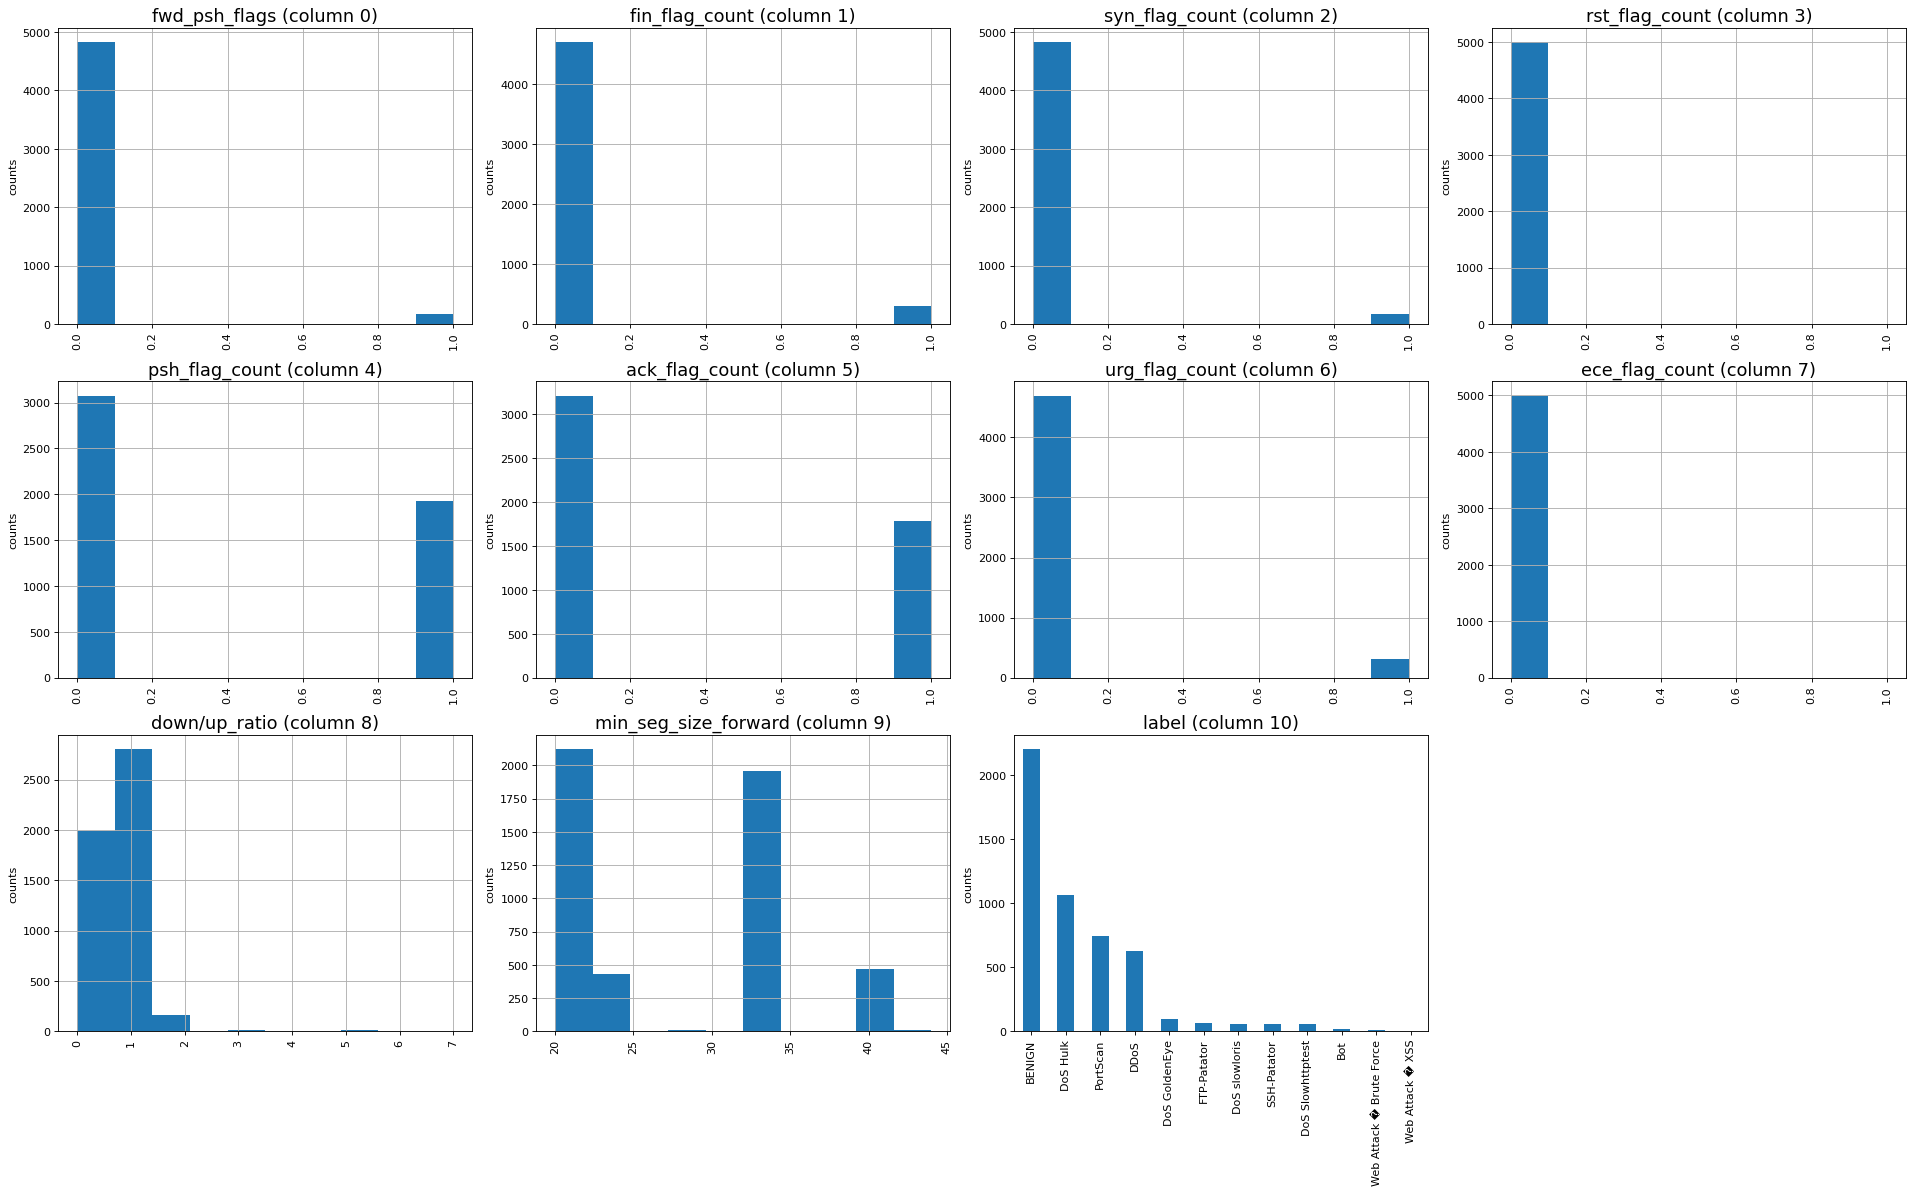

In [19]:
plotPerColumnDistribution(df.sample(5000), 20, 4)

Checking for multicollinearity in data

In [20]:
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


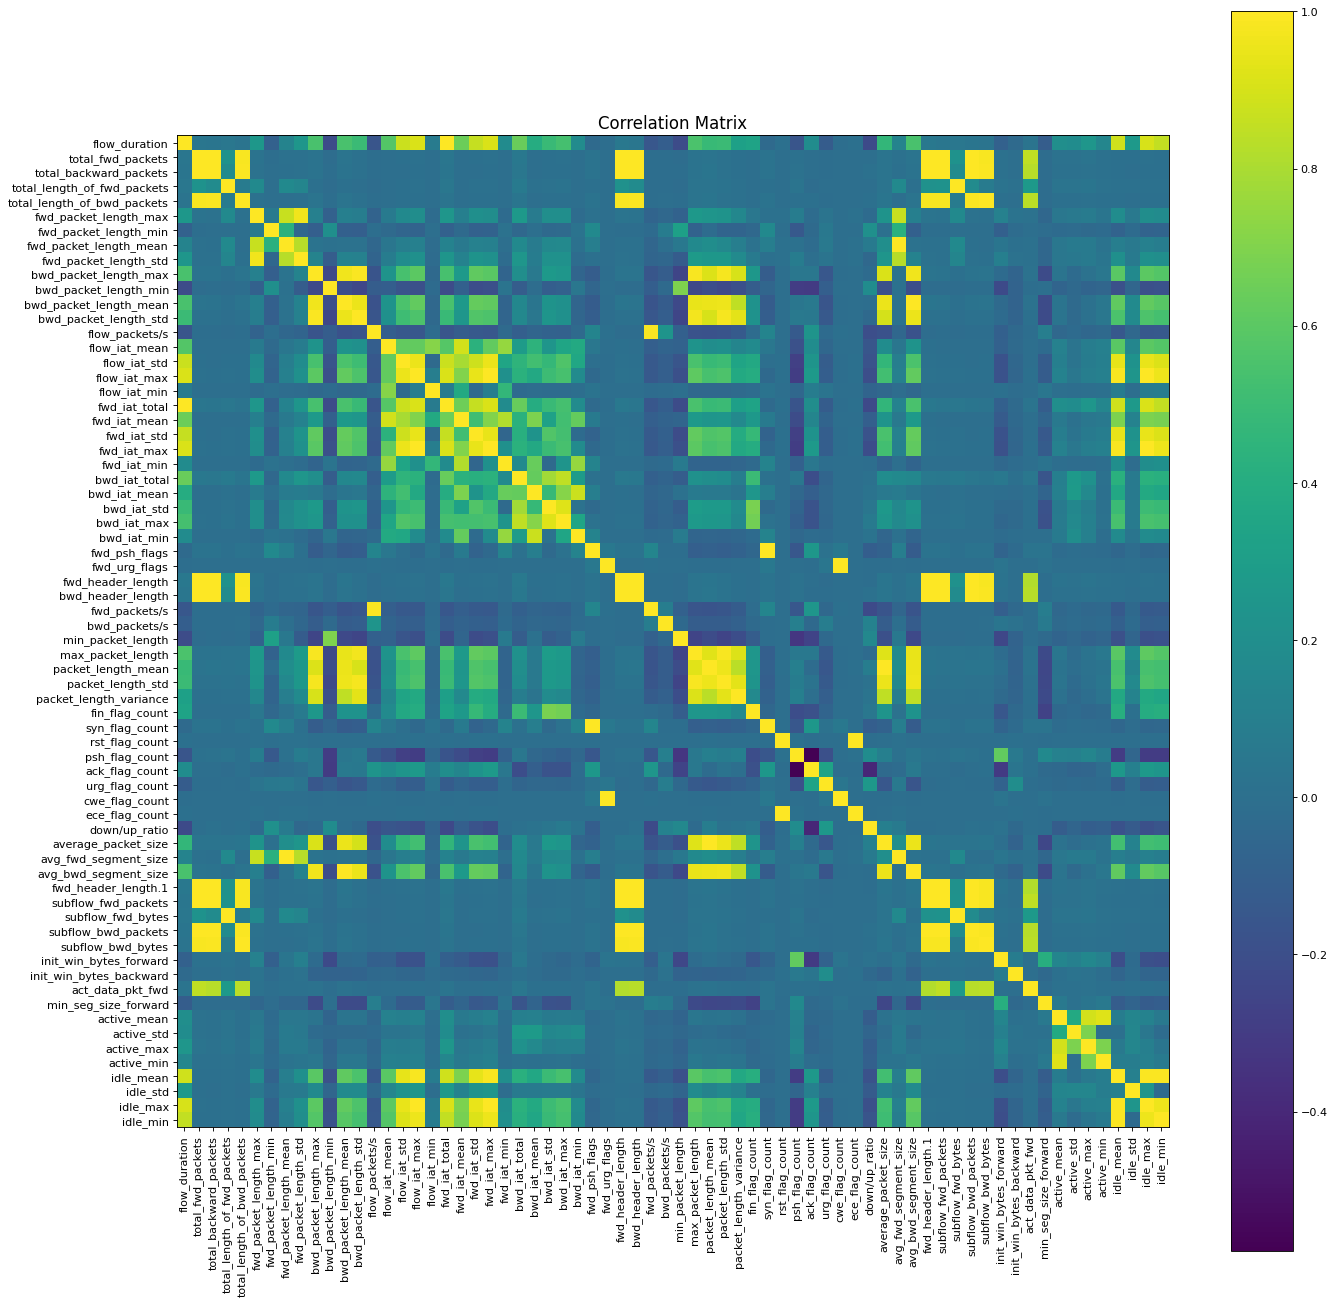

In [21]:
plotCorrelationMatrix(df.iloc[:,1:].sample(30000), 20)

In [22]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.


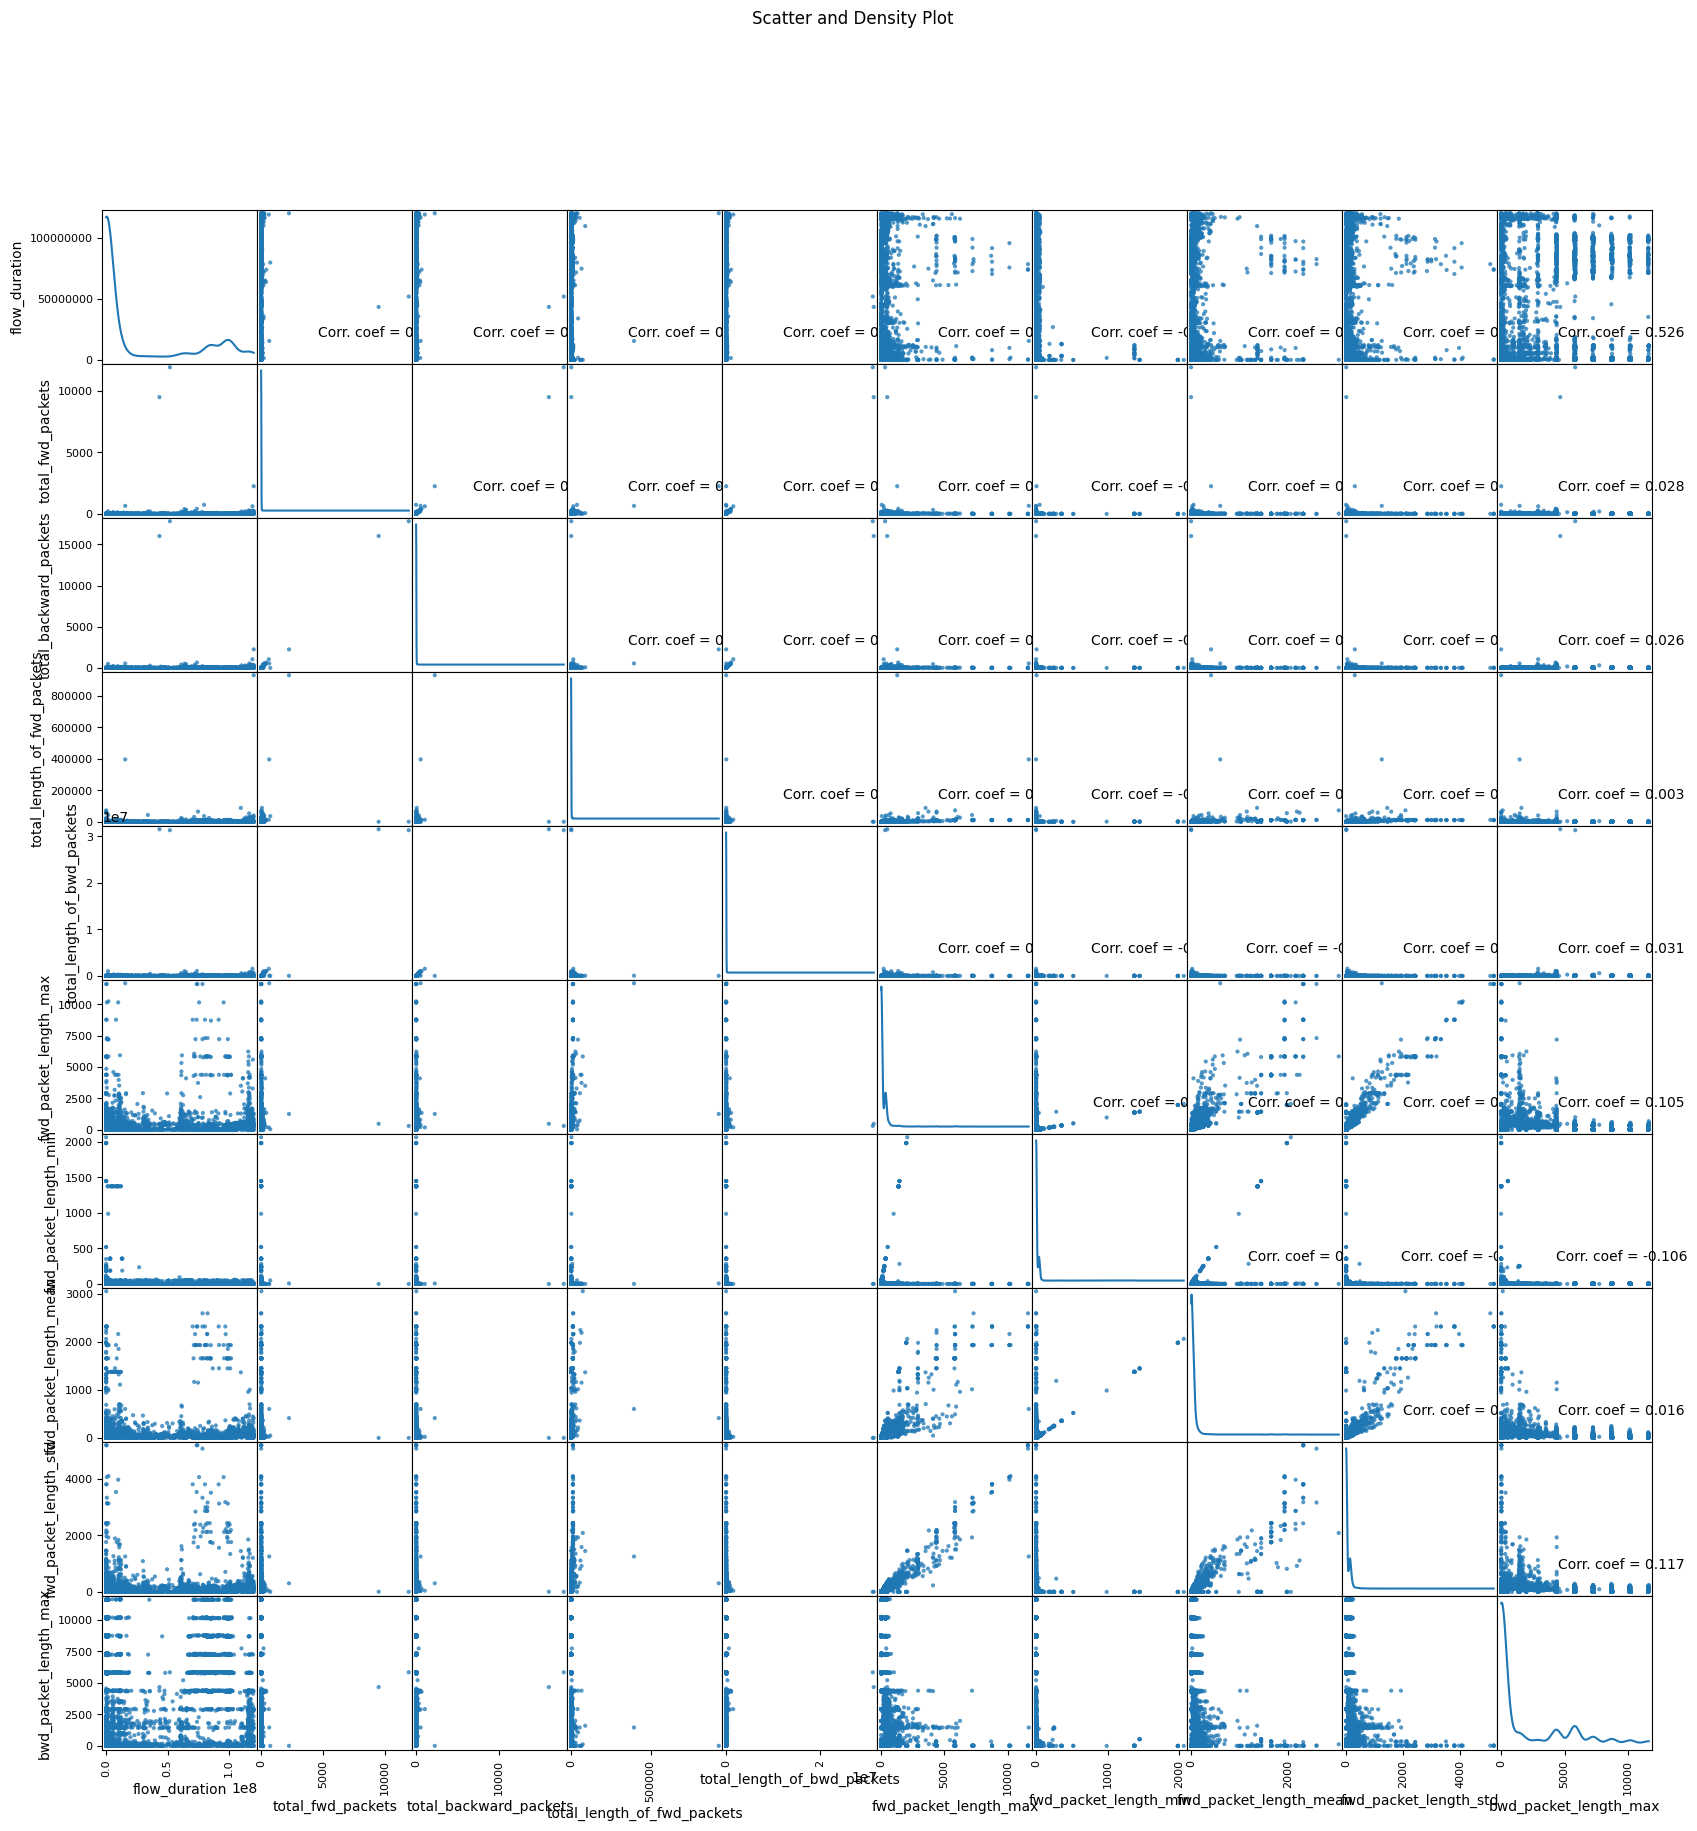

In [23]:
plotScatterMatrix(df=df.iloc[:,1:].sample(20000), plotSize=20, textSize=10)

# Data Preparation

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('label', axis=1), df.label, test_size=0.25, random_state=RANDOME_STATE)
print("Training Features:", X_train.shape)
print("\nTraining Target:", y_train.shape)
print("\nTesting Features:", X_test.shape)
print("\nTesting Target:", y_test.shape)

Training Features: (404712, 70)

Training Target: (404712,)

Testing Features: (134904, 70)

Testing Target: (134904,)


In [25]:
y_train.value_counts()

BENIGN                        179993
DoS Hulk                       86811
PortScan                       60045
DDoS                           48295
DoS GoldenEye                   7680
FTP-Patator                     5918
SSH-Patator                     4405
DoS slowloris                   4317
DoS Slowhttptest                4099
Bot                             1478
Web Attack � Brute Force        1125
Web Attack � XSS                 492
Infiltration                      26
Web Attack � Sql Injection        18
Heartbleed                        10
Name: label, dtype: int64

In [26]:
y_test.value_counts()

BENIGN                        60007
DoS Hulk                      29163
PortScan                      19615
DDoS                          16071
DoS GoldenEye                  2613
FTP-Patator                    2020
SSH-Patator                    1492
DoS slowloris                  1479
DoS Slowhttptest               1400
Bot                             488
Web Attack � Brute Force        382
Web Attack � XSS                160
Infiltration                     10
Web Attack � Sql Injection        3
Heartbleed                        1
Name: label, dtype: int64

Посмотрим на пропуски

In [27]:
df[df.columns[df.isna().any()]].isna().sum()

flow_bytes/s    488
dtype: int64

In [28]:
grouped = df.groupby('label').agg({'flow_bytes/s': ['count', lambda x: x.isna().sum()]})
grouped.columns = ['Count', 'Count_of_NaN']
grouped = grouped.reset_index()
grouped[grouped['Count_of_NaN']>0]

,label,Count,Count_of_NaN
0,BENIGN,239959,41
4,DoS Hulk,115527,447


пропуски заменим медианными значениями

In [29]:
medians = X_train['flow_bytes/s'].median()

In [30]:
X_train['flow_bytes/s'] = X_train['flow_bytes/s'].fillna(medians)
X_test['flow_bytes/s'] = X_test['flow_bytes/s'].fillna(medians)

In [31]:
X_train.isna().sum().sum()

0

In [32]:
df.columns[df.isin([np.inf, -np.inf]).any()]

Index(['flow_bytes/s', 'flow_packets/s'], dtype='object')

заменим значения бесконечности inf в столбцах flow_bytes_s и flow_packets_s на удвоенное максимальное значение в этих столбцах

In [33]:
max_value_flow_bytes_s = np.nanmax(X_train['flow_bytes/s'][X_train['flow_bytes/s'] != np.inf ])

In [50]:
max_value_flow_bytes_s

2071000000.0

In [ ]:

X_train['flow_bytes/s']. replace([np.inf , -np.inf ], 2 * max_value_flow_bytes_s, inplace= True )
X_test['flow_bytes/s']. replace([np.inf , -np.inf ], 2 * max_value_flow_bytes_s, inplace= True )

max_value_flow_packets_s = np.nanmax(X_train['flow_packets/s'][X_train['flow_packets/s'] != np.inf ])
X_train['flow_packets/s']. replace([np.inf , -np.inf ], 2 * max_value_flow_packets_s, inplace= True )
X_test['flow_packets/s']. replace([np.inf , -np.inf ], 2 * max_value_flow_packets_s, inplace= True )

In [35]:
columns_with_negatives = df.iloc[:, :-1 ].columns[(df.iloc[:, :-1 ] < 0).any()]

In [35]:
(X_train[columns_with_negatives] < 0).mean()

flow_duration              0.000032
flow_bytes/s               0.000027
flow_packets/s             0.000032
flow_iat_mean              0.000032
flow_iat_max               0.000032
flow_iat_min               0.000778
fwd_iat_min                0.000017
fwd_header_length          0.000010
bwd_header_length          0.000010
fwd_header_length.1        0.000010
init_win_bytes_forward     0.195826
init_win_bytes_backward    0.380394
min_seg_size_forward       0.000010
dtype: float64

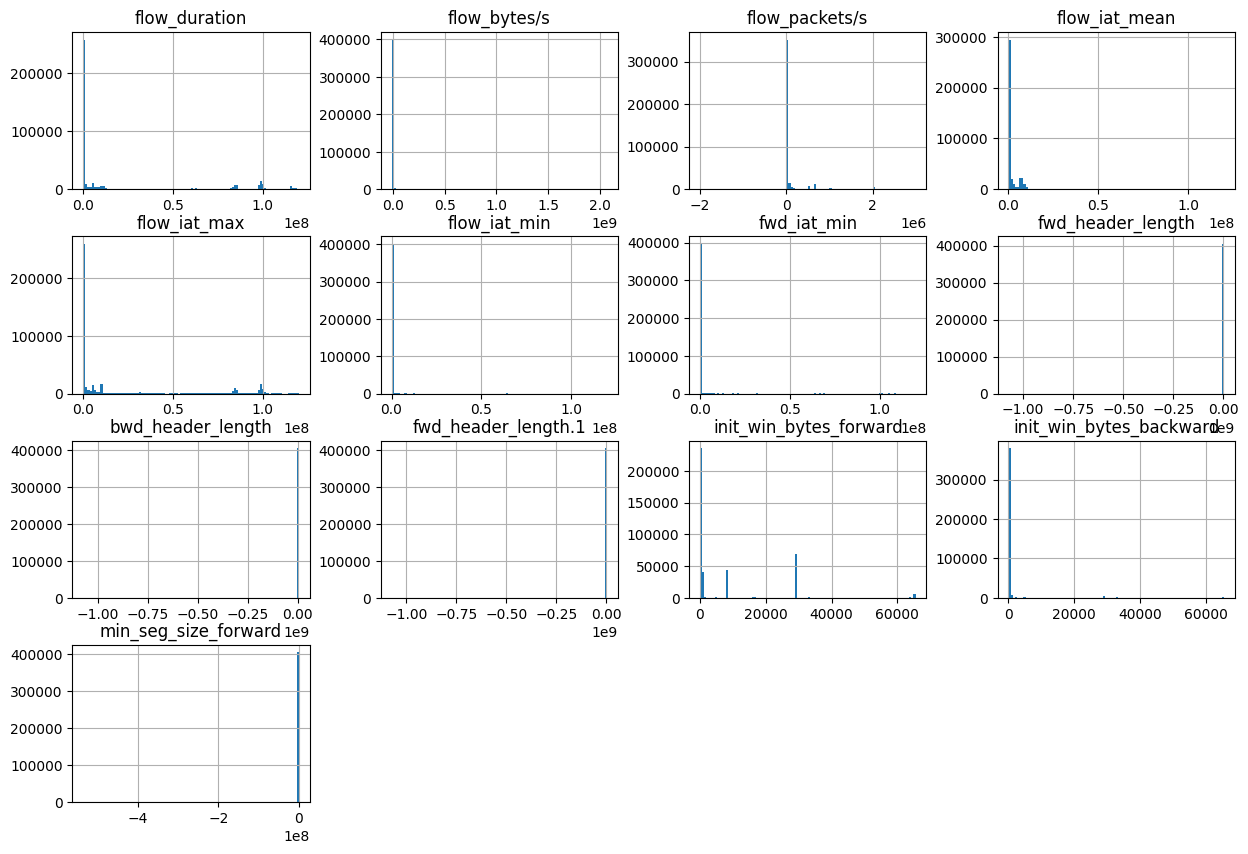

In [36]:
X_train[columns_with_negatives].hist(figsize=(15, 10), bins=100);

По идее все значения должны быть положительными

In [17]:
cat_columns = ['destination_port', 'fwd_psh_flags',
                   'fwd_urg_flags', 'fin_flag_count',
                   'syn_flag_count', 'rst_flag_count', 'psh_flag_count',
                   'ack_flag_count', 'urg_flag_count', 'cwe_flag_count',
                   'ece_flag_count']

In [38]:
numerical_columns = X_train.loc[:, ~X_train.columns.isin(cat_columns)].columns

In [39]:
scaler = StandardScaler()
scaler.fit(X_train[numerical_columns])
dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [40]:
numerical_scaled = scaler.transform(X_train[numerical_columns])
numerical_df_scaled = pd.DataFrame(numerical_scaled, columns=numerical_columns, index=X_train.index)
X_train = pd.concat([X_train.drop(columns=numerical_columns), numerical_df_scaled],  axis=1)
numerical_scaled = scaler.transform(X_test[numerical_columns])
numerical_df_scaled = pd.DataFrame(numerical_scaled, columns=numerical_columns, index=X_test.index)
X_test = pd.concat([X_test.drop(columns=numerical_columns), numerical_df_scaled], axis=1)

# Baseline ExtraTreesClassifier

In [41]:
%%time
model = ExtraTreesClassifier()
model.fit(X_train,y_train)

CPU times: user 1min 5s, sys: 203 ms, total: 1min 5s
Wall time: 1min 6s


ExtraTreesClassifier()

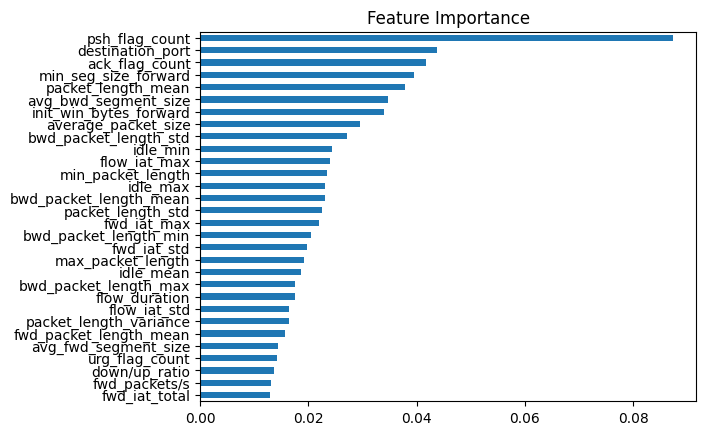

In [42]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(30).sort_values(ascending=True).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

In [43]:
test_predict = model.predict(X_test)

In [44]:
report = classification_report(y_test, test_predict, digits=4)
print(report)

                            precision    recall  f1-score   support

                    BENIGN     0.9981    0.9979    0.9980     60007
                       Bot     0.9229    0.9324    0.9276       488
                      DDoS     0.9997    0.9999    0.9998     16071
             DoS GoldenEye     0.9969    0.9973    0.9971      2613
                  DoS Hulk     0.9978    0.9991    0.9985     29163
          DoS Slowhttptest     0.9986    0.9907    0.9946      1400
             DoS slowloris     0.9966    0.9932    0.9949      1479
               FTP-Patator     0.9995    1.0000    0.9998      2020
                Heartbleed     1.0000    1.0000    1.0000         1
              Infiltration     1.0000    0.5000    0.6667        10
                  PortScan     0.9983    0.9982    0.9982     19615
               SSH-Patator     1.0000    0.9973    0.9987      1492
  Web Attack � Brute Force     0.7544    0.7801    0.7671       382
Web Attack � Sql Injection     0.4000    0.6667

# K-nearest-neighbor Classifier

In [45]:
le = LabelEncoder()

y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

In [46]:
%%time
knn=KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train,y_train_le)

CPU times: user 191 ms, sys: 87.8 ms, total: 279 ms
Wall time: 282 ms


KNeighborsClassifier(n_neighbors=15)

In [47]:
%%time
y_pred_knn=knn.predict(X_test)  # predicting target attribute on testing dataset

CPU times: user 14min, sys: 1.23 s, total: 14min 1s
Wall time: 8min 52s


In [48]:

ac=accuracy_score(y_test_le, y_pred_knn)*100  # calculating accuracy of predicted data
print("KNN-Classifier Set-Accuracy is ", ac)

KNN-Classifier Set-Accuracy is  97.79843444227005


In [49]:
print(classification_report(y_test_le, y_pred_knn, digits=4))

              precision    recall  f1-score   support

           0     0.9956    0.9593    0.9771     60007
           1     0.9079    0.6865    0.7818       488
           2     0.9993    0.9989    0.9991     16071
           3     0.9756    0.9950    0.9852      2613
           4     0.9964    0.9979    0.9972     29163
           5     0.9891    0.9764    0.9827      1400
           6     0.9845    0.9899    0.9872      1479
           7     0.9936    0.9980    0.9958      2020
           8     0.5000    1.0000    0.6667         1
           9     0.0000    0.0000    0.0000        10
          10     0.8965    0.9989    0.9449     19615
          11     0.9973    0.9879    0.9926      1492
          12     0.7054    0.8586    0.7745       382
          13     0.0000    0.0000    0.0000         3
          14     0.4125    0.2062    0.2750       160

    accuracy                         0.9780    134904
   macro avg     0.7569    0.7769    0.7573    134904
weighted avg     0.9793   

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# CatBoost

In [44]:
def preparation_data_for_catboost (df):
  df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
  selected_columns = ['bwd_psh_flags', 'bwd_urg_flags', 'fwd_avg_bytes/bulk',
       'fwd_avg_packets/bulk', 'fwd_avg_bulk_rate', 'bwd_avg_bytes/bulk',
       'bwd_avg_packets/bulk', 'bwd_avg_bulk_rate']
  df.drop(columns=selected_columns, inplace=True)
  max_value_flow_bytes_s = 1035500000
  max_value_flow_packets_s = 3000000
  df['flow_bytes/s'].replace([np.inf , -np.inf ], 2 * max_value_flow_bytes_s, inplace= True )
  df['flow_packets/s'].replace([np.inf , -np.inf ], 2 * max_value_flow_packets_s, inplace= True )
  return df

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Label', axis=1), df.Label, test_size=0.25, random_state=RANDOME_STATE)

In [46]:
X_test = preparation_data_for_catboost (X_test)
X_train = preparation_data_for_catboost (X_train)

In [47]:
categorical_features_indices = [X_train.columns.get_loc(col) for col in cat_columns]

In [48]:
categorical_features_indices

[0, 30, 31, 41, 42, 43, 44, 45, 46, 47, 48]

In [49]:
train_pool = Pool(X_train, y_train, has_header=True, cat_features=categorical_features_indices)

In [50]:
model_cb = CatBoostClassifier()
model_cb.load_model('/gdrive/MyDrive/Colab Notebooks/catboost_model_2023-10-18_raw_cat.dump')
print(model_cb.get_params())
print(model_cb.random_seed_)

{'metric_period': 100, 'task_type': 'GPU', 'loss_function': 'MultiClass', 'learning_rate': 0.1, 'iterations': 1487, 'verbose': 200}
0


In [51]:
model_cb = CatBoostClassifier(
     loss_function='MultiClass',
     iterations=1500,
     task_type='GPU',
     learning_rate=0.1
 )

In [52]:
def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-MultiClass-mean'].min()
    best_iter = cv_data['test-MultiClass-mean'].values.argmin()

    print('Best validation MultiClass score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-MultiClass-std'][best_iter],
        best_iter)
    )

In [53]:
%%time
cv_params = model_cb.get_params()
cv_data = cv(
    params = cv_params,
    pool = train_pool,
    fold_count=3,
    shuffle=True,
    partition_random_seed=0,
    #plot=True,
    stratified=True,
    verbose=False
)

Training on fold [0/3]
bestTest = 0.007296434697
bestIteration = 1463
Training on fold [1/3]
bestTest = 0.00690962814
bestIteration = 1499
Training on fold [2/3]
bestTest = 0.008143613687
bestIteration = 1484
CPU times: user 3min 44s, sys: 1min 59s, total: 5min 43s
Wall time: 3min 38s


In [54]:
print_cv_summary(cv_data)

Best validation MultiClass score : 0.0075±0.0006 on step 1499


In [55]:
model_cb = CatBoostClassifier(
     loss_function='MultiClass',
     iterations=cv_data['test-MultiClass-mean'].values.argmin(),
     task_type='GPU',
     learning_rate=0.1
 )

In [56]:
model_cb.fit(train_pool, metric_period=100, verbose=200)

0:	learn: 1.5833855	total: 98.8ms	remaining: 2m 28s
200:	learn: 0.0098939	total: 12.7s	remaining: 1m 22s
400:	learn: 0.0069587	total: 25.1s	remaining: 1m 8s
600:	learn: 0.0060778	total: 37.3s	remaining: 55.8s
800:	learn: 0.0056167	total: 49.1s	remaining: 42.8s
1000:	learn: 0.0052944	total: 59.8s	remaining: 29.7s
1200:	learn: 0.0050848	total: 1m 11s	remaining: 17.8s
1400:	learn: 0.0049238	total: 1m 24s	remaining: 5.89s
1498:	learn: 0.0048313	total: 1m 29s	remaining: 0us


In [57]:
y_predict_cb = model_cb.predict(X_test)

In [58]:
report = classification_report(y_test, y_predict_cb, digits=4)
print(report)

                            precision    recall  f1-score   support

                    BENIGN     0.9994    0.9987    0.9991     60007
                       Bot     0.9537    0.9713    0.9624       488
                      DDoS     0.9999    0.9999    0.9999     16071
             DoS GoldenEye     0.9962    0.9969    0.9966      2613
                  DoS Hulk     0.9991    0.9999    0.9995     29163
          DoS Slowhttptest     0.9950    0.9879    0.9914      1400
             DoS slowloris     0.9919    0.9932    0.9926      1479
               FTP-Patator     0.9995    1.0000    0.9998      2020
                Heartbleed     1.0000    1.0000    1.0000         1
              Infiltration     1.0000    0.7000    0.8235        10
                  PortScan     0.9984    0.9995    0.9989     19615
               SSH-Patator     1.0000    1.0000    1.0000      1492
  Web Attack � Brute Force     0.7506    0.8429    0.7941       382
Web Attack � Sql Injection     0.6000    1.0000

In [59]:
model_cb.save_model('/gdrive/MyDrive/Colab Notebooks/catboost_model_2023-10-18_raw_cat.dump')

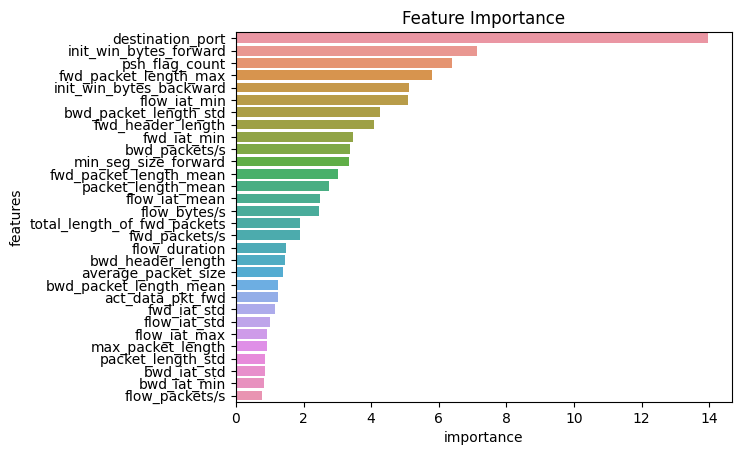

In [60]:
feat_imp = pd.DataFrame()
feat_imp['importance'] = model_cb.get_feature_importance()
feat_imp['features'] = X_train.columns
feat_imp.sort_values(by = 'importance', inplace = True, ascending = False)
feat_imp = feat_imp.head(30)

sns.barplot(y = feat_imp['features'], x = feat_imp['importance'])
plt.title("Feature Importance")
plt.show()

Самые важные признаки:

In [63]:
feat_imp.sort_values(by = 'importance', ascending = False).head(5)

,importance,features
0,13.967872,destination_port
58,7.134569,init_win_bytes_forward
44,6.401807,psh_flag_count
6,5.788130,fwd_packet_length_max
59,5.108682,init_win_bytes_backward


# Выводы
Catboost показал лучшие результаты, основной показатель метка BENIGN. Эта метка представляет нормальный  сетевой трафик.  
Полученные результаты:  
precision - 0.9994  
recall - 0.9987   
f1-score - 0.9991   
accuracy - 0.9977  

Полученная точность предсказаний удовлетворительная.
